In [20]:
import numpy as np
import pandas as pd
from matplotlib import cm
import matplotlib.pyplot as plt
from IPython.core.pylabtools import figsize
from Bio import SeqIO
import os

# sklearn package
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve,roc_auc_score

from utils import *
from Model import *

## Loading data

In [338]:
# directly to SeqVector
fasta = np.array(fasta_to_vec(read_fasta(path+'M1_M2_560.fasta')))

### <font color='steelblue'> discard identical sites across all samples

In [339]:
Seq = np.array([SeqVector.seq for SeqVector in fasta])

In [340]:
# return a list of stable sites 
size = len(Seq)
same = []
for i in range(Seq.shape[1]):
    if np.sum(Seq[:,i] == Seq[0,i]) == size:
        same.append(i)

print('number of stable sites:',len(same))

number of stable sites: 159


In [341]:
# the index of sites to keep
keep2raw = [i for i in range(Seq.shape[1]) if i not in same]

In [1202]:
keep2raw

[0,
 1,
 2,
 3,
 4,
 6,
 7,
 11,
 13,
 14,
 15,
 16,
 19,
 21,
 25,
 26,
 27,
 28,
 29,
 30,
 35,
 36,
 39,
 40,
 45,
 49,
 55,
 58,
 63,
 68,
 71,
 72,
 79,
 81,
 82,
 90,
 91,
 92,
 93,
 94,
 96,
 100,
 101,
 102,
 104,
 106,
 108,
 109,
 110,
 111,
 112,
 115,
 116,
 117,
 119,
 120,
 124,
 125,
 129,
 132,
 136,
 137,
 138,
 139,
 141,
 142,
 143,
 145,
 149,
 154,
 156,
 157,
 160,
 161,
 164,
 165,
 166,
 167,
 171,
 172,
 173,
 180,
 181,
 190,
 191,
 195,
 196,
 197,
 199,
 202,
 204,
 205,
 206,
 207,
 208,
 209,
 210,
 211,
 213,
 214,
 217,
 218,
 221,
 223,
 224,
 226,
 228,
 229,
 231,
 232,
 233,
 234,
 235,
 238,
 241,
 244,
 247,
 248,
 251,
 252,
 253,
 254,
 255,
 256,
 258,
 259,
 261,
 262,
 263,
 264,
 265,
 267,
 269,
 270,
 271,
 272,
 273,
 275,
 276,
 277,
 278,
 279,
 280,
 282,
 283,
 284,
 288,
 290,
 291,
 293,
 294,
 297,
 298,
 299,
 301,
 302,
 303,
 305,
 306,
 307,
 308,
 309,
 310,
 311,
 312,
 313,
 315,
 316,
 317,
 318,
 319,
 321,
 322,
 325,
 326

### define X and y

In [922]:
DKorGS=lambda host : 1 if host in goose else 0

In [342]:
for i in range(len(fasta)):
    fasta[i].host = 1 if fasta[i].host in goose else 0

In [846]:
X = np.array([SeqVector.vector[:,keep2raw].flatten() for SeqVector in M2]) # flatten
ID = np.arange(len(M2))
y = np.array([SeqVector.host for SeqVector in M2])

In [344]:
# double check
assert(X.shape[1] == (Seq.shape[1]-len(same))*23)

### splite 

In [345]:
ratio_of = lambda y : np.sum(y==1)/len(y)

In [918]:
X_1,X_test,ID_1,ID_test = train_test_split(X,ID,test_size=0.1,shuffle=True)
X_train,X_val,ID_train,ID_val = train_test_split(X_1,ID_1,test_size=0.1,shuffle=True)

y_train = y[ID_train];y_val = y[ID_val];y_test = y[ID_test]

In [921]:
print('------------------------------------------')
print('Ratio of positive sample in different sets')
print('------------------------------------------')
print(  'train |\t',ratio_of(y_train),
      '\n val  |\t',ratio_of(y_val),
      '\ntest  |\t',ratio_of(y_test))
print('------------------------------------------')

------------------------------------------
Ratio of positive sample in different sets
------------------------------------------
train |	 0.13245033112582782 
 val  |	 0.11764705882352941 
test  |	 0.14285714285714285
------------------------------------------


### OK 

# <font color='navy'> Model

In [351]:
import Model

In [1181]:
imp.reload(Model)

def SV(**kwarg):
    return Model.SVC_model(X_train,X_val,y_train,y_val,**kwarg)

In [1182]:
C_ls = [0.1,0.5,1,5,10,50,100,150,200,250,500,1000,2000,5000,10000]
SV_ls = [SV(**{'C':i,'kernel':'linear'}) for i in C_ls]

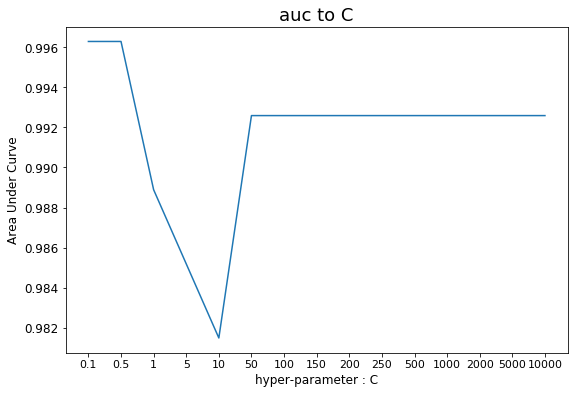

In [1183]:
Model.AUC_trace(SV_ls,'%s')

## tuning parameter

In [965]:
new_C = tuning_C_given(SV_ls)
SV_ls = [SV(**{'C':i,'kernel':'linear'}) for i in new_C]

In [985]:
def printting_training_result(SV_ls):
    print('-----------------------')
    print('   C \t \t  AUC')
    print('-----------------------')
    for model in SV_ls:
        print(' %.2f \t \t %.4f'%(model.C,model.auc))
    print('-----------------------')

The 3th training
-----------------------
   C 	 	  AUC
-----------------------
 0.10 	 	 0.9889
 0.14 	 	 0.9926
 0.19 	 	 0.9926
 0.23 	 	 0.9926
 0.28 	 	 0.9963
 0.32 	 	 0.9963
 0.37 	 	 0.9926
 0.41 	 	 0.9926
 0.46 	 	 0.9889
 0.50 	 	 0.9889
-----------------------


In [963]:
new_C

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])

In [1185]:
model=SV_ls[1]

In [1192]:
ID_train[model.support_]

array([337,  98,  94, 230, 132, 133, 252,  56, 268,  82, 267,  12, 515,
       307, 318, 216,  35, 327, 139, 498, 241, 194,  85,  50, 262, 151,
       138, 275, 348,   8,  28, 296,  83, 259, 213,  15, 325, 182,  34,
       303, 375, 360, 382, 319, 222, 364, 365,  87, 257, 371, 254, 380,
       321, 305, 284, 361, 315, 140, 368, 211, 304, 317])

In [1189]:
ID_train[model.support_][np.where(y[ID_train[model.support_]] == 0)[0]]

array([337,  98,  94, 230, 132, 133, 252,  56, 268,  82, 267,  12, 515,
       307, 318, 216,  35, 327, 139, 498, 241, 194,  85,  50, 262, 151,
       138, 275, 348,   8,  28, 296,  83, 259, 213,  15, 325, 182,  34])

In [1195]:
[M2[i].host for i in ID_train[model.support_][np.where(y[ID_train[model.support_]] == 1)[0]]]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

In [1173]:
imp.reload(Model)

<module 'Model' from '/home/ZwZ/script/support_virus/Model.py'>

In [1174]:
omega = Model.SVM_omega(SV_ls[1].coef_)

In [1175]:
omega.DF.shape

(47, 4)

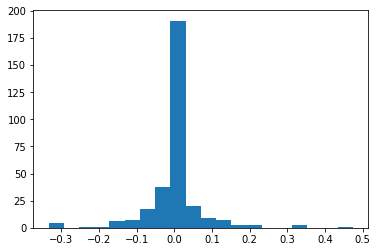

In [1201]:
omega.non_zero_hist()

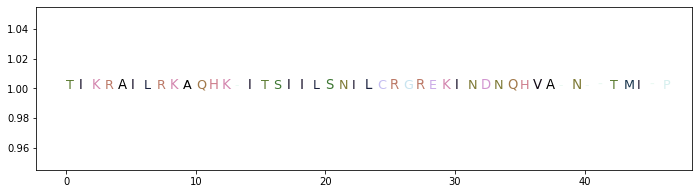

In [1176]:
omega.letter_plot()

## what 's support vector

In [1179]:
ID_train[model.support_]

array([ 58,  98, 205, 458,  23,  31,  42,  45, 527, 267,  92, 103, 311,
       364, 183, 290, 548, 154, 396, 233, 204, 342, 106,  72, 462, 505,
       126,  83,  97, 137,  54, 465, 392, 435, 442,   6, 359,  18, 136,
       149,  34, 482,  16,  17, 132, 515, 307, 494, 403,  93,  26, 214,
       130, 213, 445,  88, 185, 418, 263])

In [949]:
path+'M1_M2_560.fasta'

'/home/ZwZ/database/M/linsi/M1_M2_560.fasta'

In [988]:
import joblib

In [ ]:
joblib.dump(,'SV_{}.model'.format(repeat+1))

In [992]:
args.times_of_training

3

In [993]:
true_ratio = ratio_of(y)